<a href="https://colab.research.google.com/github/chetanrajhans/Case-Study-Automatic-Ticket-Classification/blob/Develop/Automatic_Ticket_Classification_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [2]:
# Importing Required Libraries
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
from tqdm import tqdm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#from plotly.offline import plot
#import plotly.graph_objects as go
#import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

from nltk.stem import WordNetLemmatizer

# hide warnings
import warnings
warnings.filterwarnings('ignore')
tqdm.pandas()

In [3]:
# Importing nltk packages and libraries
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [4]:
# change the display properties of pandas
pd.set_option('display.max_colwidth', None)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [5]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Opening JSON file
#f = open('complaints-2021-05-14_08_16.json') #Update local path of files if running on local machine
f = open('/content/drive/MyDrive/Datasets/NLP Ticket Classification/complaints-2021-05-14_08_16.json') #Google Drive path of file
# returns JSON object as
# a dictionary
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [7]:
# Inspect the dataframe to understand the given data.
# Chekcing first 5 rows
df.head(5)


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [8]:
# Checking Shape of the data
df.shape

(78313, 22)

In [9]:
# Checking Summary Information about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [10]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [11]:
#Assign new column names, removing '_' and '_source' from column names
df.rename(columns={'_index':'index',
  '_type':'type',
  '_id':'id',
  '_score':'score',
  '_source.tags':'tags',
  '_source.zip_code':'zip_code',
 '_source.complaint_id':'complaint_id',
 '_source.issue':'issue',
 '_source.date_received':'date_received',
 '_source.state':'state',
 '_source.consumer_disputed':'consumer_disputed',
 '_source.product':'product',
 '_source.company_response':'company_response',
 '_source.company':'company',
 '_source.submitted_via':'submitted_via',
 '_source.date_sent_to_company':'date_sent_to_company',
 '_source.company_public_response':'company_public_response',
 '_source.sub_product':'sub_product',
 '_source.timely':'timely',
 '_source.complaint_what_happened':'complaint_what_happened',
 '_source.sub_issue':'sub_issue',
 '_source.consumer_consent_provided':'consumer_consent_provided'},inplace=True)

In [12]:
#Checking nulls values in each columns
df.isnull().sum()

,0
index,0
type,0
id,0
score,0
tags,67413
zip_code,6757
complaint_id,0
issue,0
date_received,0
state,1991


In [18]:
# 'complaint_what_happened' is showing 0 nulls, Checking rows where complaint_what_happened is blank
df[df['complaint_what_happened']==''].shape

(0, 22)

In [14]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'].replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [15]:
# Again checking rows where 'complaint_what_happened' is na
df[df['complaint_what_happened'].isna()]

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,NaN,Debt is not yours,Consent not provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,NaN,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,NaN,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,NaN,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,NaN,Problem using a debit or ATM card,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78304,complaint-public-v2,complaint,3080086,0.0,None,76107,3080086,Applying for a mortgage or refinancing an existing mortgage,2018-11-22T12:00:00-05:00,TX,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-11-22T12:00:00-05:00,None,Conventional home mortgage,Yes,NaN,None,Other
78305,complaint-public-v2,complaint,3103013,0.0,Older American,863XX,3103013,Closing an account,2018-12-17T12:00:00-05:00,AZ,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2018-12-18T12:00:00-05:00,None,Other banking product or service,Yes,NaN,Funds not received from closed account,Consent not provided
78306,complaint-public-v2,complaint,3099437,0.0,None,11217,3099437,Managing an account,2018-12-12T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2018-12-18T12:00:00-05:00,None,Checking account,Yes,NaN,Deposits and withdrawals,N/A
78307,complaint-public-v2,complaint,3156336,0.0,None,074XX,3156336,Applying for a mortgage or refinancing an existing mortgage,2019-02-19T12:00:00-05:00,NJ,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-02-19T12:00:00-05:00,None,Conventional home mortgage,Yes,NaN,None,Other


In [17]:
#Checking Null values again,count of 'complaint_what_happened' is updated now
df.isnull().sum()

,0
index,0
type,0
id,0
score,0
tags,67413
zip_code,6757
complaint_id,0
issue,0
date_received,0
state,1991


In [19]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'],inplace=True)

In [21]:
#Checking null again aftet dropping null value rows from 'complaint_what_happened'
df.isnull().sum()

,0
index,0
type,0
id,0
score,0
tags,17256
zip_code,4645
complaint_id,0
issue,0
date_received,0
state,143


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [22]:
# Write your function here to clean the text and remove all the unnecessary elements.

def clean_text(text):
    #Making text Lower case
    text = text.lower()

    #Removing text in Square brackets []
    text = re.sub(r'\[[^\]]+\]',' ',text)

    #Removing Puntuations
    text = re.sub(r'[^\w\s/]',' ',text)

    #Removing words containg numbers
    text = re.sub(r'\b[a-zA-Z]*\d+[a-zA-Z]+\b|\b[a-zA-Z]+\d+\w*\b',' ',text)

    return text

In [23]:
# Applying 'clean_text' function to 'complaint_what_happened' column and creating a new column 'complaint_what_happened_clean'
df['complaint_what_happened_cleaned'] = df['complaint_what_happened'].progress_apply(lambda x : clean_text(x))

100%|██████████| 21072/21072 [00:04<00:00, 4406.69it/s]


In [24]:
#Write your function to Lemmatize the texts
lemmatizer = WordNetLemmatizer() #Initiating Lemmatizer

def lemmatize(text):
    words = word_tokenize(text) #Tokenizing words

    #lemmatized_text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())
    lemmatized_text = ' '.join(lemmatizer.lemmatize(word) for word in words) # Lemmatize each word
    return lemmatized_text

In [25]:
# Applying 'lemmatize' function to 'complaint_what_happened_clean' column to get lemma and creating a new column 'complaint_what_happened_lemma'
df['complaint_what_happened_lemma'] = df['complaint_what_happened_cleaned'].progress_apply(lambda x:lemmatize(x))

100%|██████████| 21072/21072 [00:39<00:00, 531.55it/s]


In [26]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean = df[['complaint_what_happened_cleaned','complaint_what_happened_lemma']]

In [ ]:
df_clean.head(5)

,complaint_what_happened_cleaned,complaint_what_happened_lemma
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember service in 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help
2,i upgraded my xxxx xxxx card in xx/xx/2018 and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent xxxx has the recording of the agent who was misled me,i upgraded my xxxx xxxx card in xx/xx/2018 and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent xxxx ha the recording of the agent who wa misled me
10,chase card was reported on xx/xx/2019 however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card wa reported on xx/xx/2019 however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not extend credit without verifying the identity of the applicant
11,on xx/xx/2018 while trying to book a xxxx xxxx ticket i came across an offer for 300 00 to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on xx/xx/2018 notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on xx/xx/2018 this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on xx/xx/2018 while trying to book a xxxx xxxx ticket i came across an offer for 300 00 to be applied towards the ticket if i applied for a reward card i put in my information for the offer and within less than a minute wa notified via the screen that a decision could not be made i immediately contacted xxxx and wa referred to chase bank i then immediately contacted c

In [27]:
#Write your function to extract the POS tags
def extract_nouns_column(text):
    words = word_tokenize(text)  # Tokenize text
    tagged_words = pos_tag(words)  # Get POS tags
    lemmatized_nouns = [lemmatizer.lemmatize(word) for word, tag in tagged_words if tag == 'NN']  # Keep only nouns
    return ' '.join(lemmatized_nouns)  # Return as a single string

In [ ]:
'''
df['complaint_what_happened_lemma'][1]
words = word_tokenize(df['complaint_what_happened_lemma'][1])
tagged_words = pos_tag(words)
lemmatized_nouns = [lemmatizer.lemmatize(word) for word, tag in tagged_words if tag == 'NN']
' '.join(lemmatized_nouns)
'''

"\ndf['complaint_what_happened_lemma'][1]\nwords = word_tokenize(df['complaint_what_happened_lemma'][1])\ntagged_words = pos_tag(words)\nlemmatized_nouns = [lemmatizer.lemmatize(word) for word, tag in tagged_words if tag == 'NN']\n' '.join(lemmatized_nouns)\n"

In [28]:
#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] =  df_clean['complaint_what_happened_lemma'].progress_apply(extract_nouns_column)

100%|██████████| 21072/21072 [03:50<00:00, 91.28it/s] 


In [29]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head(5)

,complaint_what_happened_cleaned,complaint_what_happened_lemma,complaint_POS_removed
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember service in 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,morning name stop bank cardmember service debt verification statement i bank debt mail month debt i right information consumer chase account advance help
2,i upgraded my xxxx xxxx card in xx/xx/2018 and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent xxxx has the recording of the agent who was misled me,i upgraded my xxxx xxxx card in xx/xx/2018 and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent xxxx ha the recording of the agent who wa misled me,i card wa agent upgrade date agent wa information order account date xx/xx/xxxx consent xxxx recording agent
10,chase card was reported on xx/xx/2019 however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card wa reported on xx/xx/2019 however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not extend credit without verifying the identity of the applicant,card wa xx/xx/2019 application identity consent service credit identity applicant
11,on xx/xx/2018 while trying to book a xxxx xxxx ticket i came across an offer for 300 00 to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on xx/xx/2018 notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on xx/xx/2018 this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on 

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




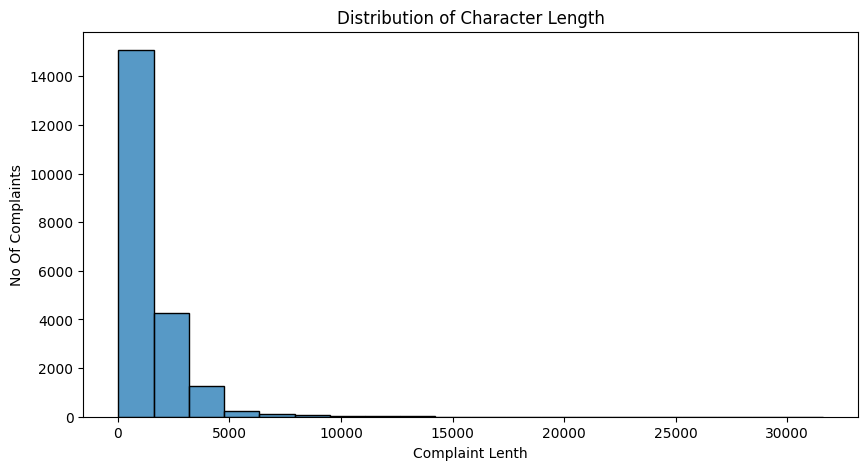

In [30]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean['Complaint_Char_length'] = [len(x) for x in df_clean['complaint_what_happened_cleaned']] # Creating Char Length column

#Visualizing complaints by character length
plt.figure(figsize=(10,5))
sns.histplot(data=df_clean,x=df_clean['Complaint_Char_length'],bins=20)
plt.title('Distribution of Character Length')
plt.xlabel('Complaint Lenth')
plt.ylabel('No Of Complaints')
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

In [31]:
# Installing Wordcloud
!pip install wordcloud

In [32]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

In [35]:
'''
all_text = ' '.join(df_clean['complaint_what_happened_cleaned']) # Creating a single string
words = all_text.split() #Splitting string to get words
word_counts = Counter(words) # Couning word frequency using counter
top_words = dict(word_counts.most_common(40)) # Creating dictionary for top 40 most common words

#stop_words = set(STOPWORDS)
custom_stopwords = STOPWORDS.union({'xx/xx/xxxx','xx','X','xxxx'})
wordcloud = WordCloud(stopwords=custom_stopwords,width=800, height=400, background_color="white").generate_from_frequencies(top_words)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
'''

'\nall_text = \' \'.join(df_clean[\'complaint_what_happened_cleaned\']) # Creating a single string \nwords = all_text.split() #Splitting string to get words\nword_counts = Counter(words) # Couning word frequency using counter \ntop_words = dict(word_counts.most_common(40)) # Creating dictionary for top 40 most common words\n\n#stop_words = set(STOPWORDS)\ncustom_stopwords = STOPWORDS.union({\'xx/xx/xxxx\',\'xx\',\'X\',\'xxxx\'})\nwordcloud = WordCloud(stopwords=custom_stopwords,width=800, height=400, background_color="white").generate_from_frequencies(top_words)\n\n# Display the word cloud\nplt.figure(figsize=(10, 5))\nplt.imshow(wordcloud, interpolation="bilinear")\nplt.axis("off")\nplt.show()\n'

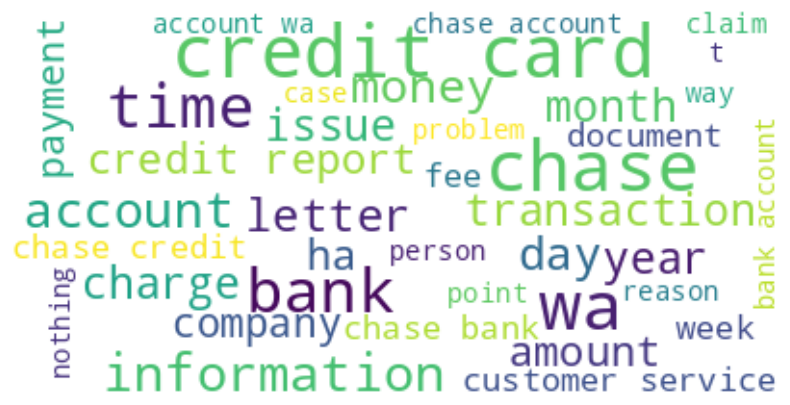

In [34]:
#stop_words = set(STOPWORDS)
custom_stopwords = STOPWORDS.union({'xx/xx/xxxx','xx','X','xxxx'})

word_cloud = WordCloud(
    background_color='White',
    stopwords= custom_stopwords,
    max_font_size=38,
    max_words=38,
    random_state=42
).generate((" ".join(df_clean['complaint_POS_removed']))) #Convert column to a single string

plt.figure(figsize=(10, 5))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [36]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [37]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
df_clean['unigrams'] = df_clean['Complaint_clean'].progress_apply(word_tokenize)

100%|██████████| 21072/21072 [00:04<00:00, 4602.25it/s]


In [38]:
#Print the top 10 words in the unigram frequency
all_unigrams = [word for word_list in df_clean['unigrams'] for word in word_list]
unigram_freq = Counter(all_unigrams)

# Get the top 30 unigrams
top_30_unigrams = unigram_freq.most_common(30)

# Convert to DataFrame for better visualization
df_top_unigrams = pd.DataFrame(top_30_unigrams, columns=['Unigram', 'Frequency'])

print(df_top_unigrams)

        Unigram  Frequency
0             i     130359
1         chase      51685
2       account      47744
3          xxxx      39901
4        credit      33146
5            wa      32760
6          card      29644
7          bank      28302
8       payment      21331
9          time      16292
10          day      13236
11   xx/xx/xxxx      12981
12       charge      12376
13        money      11997
14         loan      11034
15        check      10248
16       letter       9692
17  information       9666
18          fee       8678
19  transaction       8660
20       number       8628
21        month       8555
22         year       8439
23       amount       8370
24     mortgage       8201
25     customer       8192
26           ha       8164
27      balance       7774
28      company       7643
29      service       7619


In [39]:
#Unigrams after Removing Stop Words

stop_words = set(STOPWORDS)
# Add custom stopwords
custom_stopwords = {'xx', 'xxxx', 'xx/xx/xxxx', '00/00/0000', 'dummyword'}
stop_words.update(custom_stopwords)

df_clean['unigrams'] = df_clean['Complaint_clean'].progress_apply(
    lambda x: [word for word in word_tokenize(x) if word.lower() not in stop_words]
)

all_unigrams = [word for word_list in df_clean['unigrams'] for word in word_list]
unigram_freq = Counter(all_unigrams)

# Get the top 30 unigrams
top_30_unigrams = unigram_freq.most_common(30)

# Convert to DataFrame for better visualization
df_top_unigrams = pd.DataFrame(top_30_unigrams, columns=['Unigram', 'Frequency'])

print(df_top_unigrams)

100%|██████████| 21072/21072 [00:06<00:00, 3343.82it/s]


        Unigram  Frequency
0         chase      51685
1       account      47744
2        credit      33146
3            wa      32760
4          card      29644
5          bank      28302
6       payment      21331
7          time      16292
8           day      13236
9        charge      12376
10        money      11997
11         loan      11034
12        check      10248
13       letter       9692
14  information       9666
15          fee       8678
16  transaction       8660
17       number       8628
18        month       8555
19         year       8439
20       amount       8370
21     mortgage       8201
22     customer       8192
23           ha       8164
24      balance       7774
25      company       7643
26      service       7619
27        phone       7600
28       report       7234
29        fraud       7129


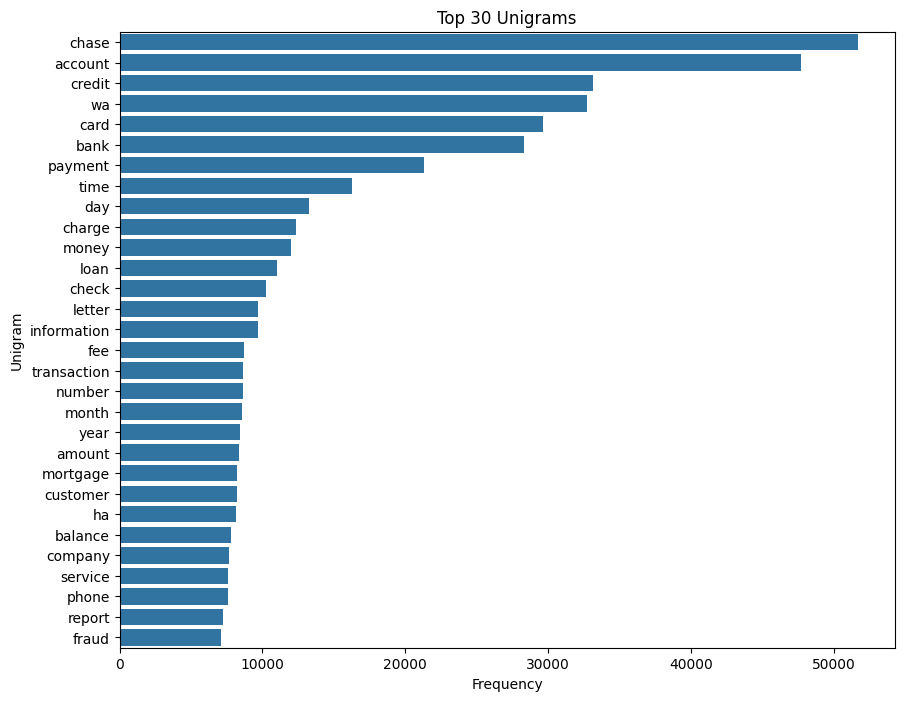

In [40]:
plt.figure(figsize=(10,8))
sns.barplot(data =df_top_unigrams,y = df_top_unigrams['Unigram'],x=df_top_unigrams['Frequency'] )
plt.title('Top 30 Unigrams')
#plt.gca().invert_yaxis()
plt.show()

In [52]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).

from nltk.util import bigrams, trigrams #Importing bigram and trigrams from nltk

stop_words = set(STOPWORDS) #Setting Stopwords
# Add custom stopwords
custom_stopwords = {'xx', 'xxxx', 'xx/xx/xxxx', '00/00/0000', 'dummyword'}
stop_words.update(custom_stopwords)

def get_ngrams(text, ngram_type='bigram'):
    words = [word for word in word_tokenize(text) if word.lower() not in stop_words]
    if ngram_type == 'bigram':
        return list(bigrams(words))  # Generate bigrams
    elif ngram_type == 'trigram':
        return list(trigrams(words))  # Generate trigrams
    return []

df_clean['bigrams'] = df_clean['Complaint_clean'].progress_apply(lambda x: get_ngrams(x, 'bigram'))
all_bigram = [pair for pair_list in df_clean['bigrams'] for pair in pair_list]
bigram_freq = Counter(all_bigram)
top_30_bigrams = bigram_freq.most_common(30)

100%|██████████| 21072/21072 [00:06<00:00, 3194.36it/s]


In [53]:
#Print the top 10 words in the bigram frequency
print(pd.DataFrame(bigram_freq.most_common(10), columns=['Bigram', 'Frequency']))

                Bigram  Frequency
0       (credit, card)      12845
1     (credit, report)       3887
2      (chase, credit)       3126
3  (customer, service)       3087
4     (chase, account)       3027
5        (chase, bank)       2930
6        (account, wa)       2874
7     (account, chase)       2870
8      (bank, account)       2851
9   (account, account)       2412


In [54]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
df_clean['trigram'] = df_clean['Complaint_clean'].progress_apply(lambda x: get_ngrams(x, 'trigram'))

all_trigram = [triplet for triplets_list in df_clean['trigram'] for triplet in triplets_list]
trigram_freq  = Counter(all_trigram)
top_30_trigrams = trigram_freq.most_common(30)

100%|██████████| 21072/21072 [00:06<00:00, 3141.90it/s]


In [55]:
#Print the top 10 words in the trigram frequency
print(pd.DataFrame(trigram_freq.most_common(10), columns=['Trigram', 'Frequency']))

                       Trigram  Frequency
0        (chase, credit, card)       2150
1      (credit, card, account)       1046
2      (credit, card, company)        994
3        (credit, card, chase)        709
4    (inquiry, credit, report)        525
5       (credit, card, credit)        495
6      (account, credit, card)        408
7  (credit, reporting, agency)        394
8         (bank, credit, card)        393
9         (card, credit, card)        374


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [56]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [57]:
#All masked texts has been removed
df_clean.head(5)

,complaint_what_happened_cleaned,complaint_what_happened_lemma,complaint_POS_removed,Complaint_Char_length,Complaint_clean,unigrams,bigrams,trigram
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember service in 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,morning name stop bank cardmember service debt verification statement i bank debt mail month debt i right information consumer chase account advance help,486,morning name stop bank cardmember service debt verification statement i bank debt mail month debt i right information consumer chase account advance help,"[morning, name, stop, bank, cardmember, service, debt, verification, statement, bank, debt, mail, month, debt, right, information, consumer, chase, account, advance, help]","[(morning, name), (name, stop), (stop, bank), (bank, cardmember), (cardmember, service), (service, debt), (debt, verification), (verification, statement), (statement, bank), (bank, debt), (debt, mail), (mail, month), (month, debt), (debt, right), (right, information), (information, consumer), (consumer, chase), (chase, account), (account, advance), (advance, help)]","[(morning, name, stop), (name, stop, bank), (stop, bank, cardmember), (bank, cardmember, service), (cardmember, service, debt), (service, debt, verification), (debt, verification, statement), (verification, statement, bank), (statement, bank, debt), (bank, debt, mail), (debt, mail, month), (mail, month, debt), (month, debt, right), (debt, right, information), (right, information, consumer), (information, consumer, chase), (consumer, chase, account), (chase, account, advance), (account, advance, help)]"
2,i upgraded my xxxx xxxx card in xx/xx/2018 and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent xxxx has the recording of the agent who was misled me,i upgraded my xxxx xxxx card in xx/xx/2018 and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent xxxx ha the recording of the agent who wa misled me,i card wa agent upgrade date agent wa information order account date xx/xx/xxxx consent xxxx recording agent,355,i card wa agent upgrade date agent wa information order account date xx/xx/ consent recording agent,"[card, wa, agent, upgrade, date, agent, wa, information, order, account, date, consent, recording, agent]","[(card, wa), (wa, agent), (agent, upgrade), (upgrade, date), (date, agent), (agent, wa), (wa, information), (information, order), (order, account), (account, date), (date, consent), (consent, recording), (recording, agent)]","[(card, wa, agent), (wa, agent, upgrade), (agent, upgrade, date), (upgrade, date, agent), (date, agent, wa), (agent, wa, information), (wa, information, order), (information, order, account), (order, account, date), (account, date, consent), (date, consent, recording), (consent, rec

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [58]:
#Write your code here to initialise the TfidfVectorizer
tfidf = TfidfVectorizer(max_df=0.95,min_df=2,stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [59]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])

In [60]:
#print(tfidf_model.toarray())
pd.DataFrame(dtm.toarray(),columns=tfidf.get_feature_names_out())

,00,09,10,11,12,14,15,16,17,18,...,youth,youve,yr,ytd,zero,zeroed,zip,zipcode,zombie,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.141832,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [61]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [62]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics,random_state=40) #write your code here

In [63]:
#nmf_model.fit_transform(dtm)
W = nmf_model.fit_transform(dtm)  # Document-topic matrix
H = nmf_model.components_       # Topic-term matrix
len(tfidf.get_feature_names_out())

6673

In [64]:
words = np.array(tfidf.get_feature_names_out())
words

array(['00', '09', '10', ..., 'zipcode', 'zombie', 'zone'], dtype=object)

In [ ]:
'''
topic_words = pd.DataFrame(np.zeros((num_topics,15)),
             index=[f'Topic {i + 1}' for i in range(num_topics)],
             columns=[f'Word {i + 1}' for i in range(15)]).astype(str)

for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words
'''

"\ntopic_words = pd.DataFrame(np.zeros((num_topics,15)),\n             index=[f'Topic {i + 1}' for i in range(num_topics)],\n             columns=[f'Word {i + 1}' for i in range(15)]).astype(str)\n\nfor i in range(num_topics):\n    ix = H[i].argsort()[::-1][:15]\n    topic_words.iloc[i] = words[ix]\n\ntopic_words\n"

In [65]:
topic_words = pd.DataFrame(np.zeros((15,num_topics)),
             #columns=[f'Topic {i + 1}' for i in range(num_topics)],
             columns=[f'{i}' for i in range(num_topics)],
             index=[f'Word {i + 1}' for i in range(15)]).astype(str)

for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words[f'{i}'] = words[ix]

topic_words

,0,1,2,3,4
Word 1,account,card,payment,xx,credit
Word 2,bank,credit,loan,charge,report
Word 3,check,charge,mortgage,wa,inquiry
Word 4,money,chase,chase,dispute,bureau
Word 5,chase,balance,home,chase,account
Word 6,fund,wa,month,2020,score
Word 7,wa,fee,modification,letter,reporting
Word 8,deposit,purchase,time,transaction,debt
Word 9,branch,service,year,claim,company
Word 10,day,time,wa,2018,information


In [66]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
'''
W_df = pd.DataFrame(W, columns=[f'{i + 1}' for i in range(num_topics)])
W_df['max_topic'] = W_df.apply(lambda x: x.idxmax(), axis=1)
W_df

np.argmax(W,axis=1)
'''
np.argmax(W,axis=1)

array([0, 3, 3, ..., 4, 1, 2])

In [67]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = np.argmax(W,axis=1)

In [69]:
#Print the first 5 Complaint for each of the Topics
df_clean[['complaint_what_happened_cleaned','Topic']].groupby('Topic').head(5).sort_values('Topic')

,complaint_what_happened_cleaned,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,0
14,my grand son give me check for 1600 00 i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase 2 times they told him i should call not him to verify the check owner he is out the country most the time date happen xx/xx/2018 check number xxxx claim number is xxxx with chase,0
17,with out notice j p morgan chase restricted my account by my debit card tuesday xx/xx/2019 on thursday xx/xx/2019 i went into a branch after being advised by a customer service representative that my account would actually be closed i went into the branch to see how i can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned the bank associate and the customer service representative assured me that the funds would post but they may take an additional business day that saturday i attempted to go inside of a branch yet again to retrieve my funds that actually did post on friday xx/xx/2019 upon looking at my account i realize that the funds have been reversed and no longer were present on my current statement ive been called and i was told that it may take two business day stating tuesday xx/xx/xxxx would be the date that my funds would be available to withdraw from a bank teller only now chase is informing me that i will be mailed a check into the three business days to recover the funds that are owed to me and left in my account currently unfortunately this has put me in an additional financial bind do two fees from late rent late car payments etc i am not being a short or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document i am not being a shored or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document this situation is truly affecting my livelihood and they dont seem to want to deal with me professionally thank you,0
21,on xxxx xx/xx/2019 i made a 300 00 payment to an online retailer using chase quick pay with xxxx on the chase website i realized that this was a scam website after no confirmation product or response to any inquiries regarding the order and contacted chase to get more information about the transaction to attempt getting a refund through the retailers bank \n\ni contacted chase via a secured message on xx/xx/2019 explaining what happened and asked is there a way to reverse this transaction or do you have a contact at xxxx that can give me more information about the recipient that xxxx my message was reviewed and i received a response restating my original email and informing me that the transfer has been completed howeve

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [70]:
#Create the dictionary of Topic names and Topics
Topic_names = {0: 'Bank Account services',
    1: 'Credit card or prepaid card',
    2: 'Others',
    3: 'Theft/Dispute Reporting',
    4: 'Mortgage/Loan'   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)


In [71]:
df_clean.head(5)

,complaint_what_happened_cleaned,complaint_what_happened_lemma,complaint_POS_removed,Complaint_Char_length,Complaint_clean,unigrams,bigrams,trigram,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember service in 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,morning name stop bank cardmember service debt verification statement i bank debt mail month debt i right information consumer chase account advance help,486,morning name stop bank cardmember service debt verification statement i bank debt mail month debt i right information consumer chase account advance help,"[morning, name, stop, bank, cardmember, service, debt, verification, statement, bank, debt, mail, month, debt, right, information, consumer, chase, account, advance, help]","[(morning, name), (name, stop), (stop, bank), (bank, cardmember), (cardmember, service), (service, debt), (debt, verification), (verification, statement), (statement, bank), (bank, debt), (debt, mail), (mail, month), (month, debt), (debt, right), (right, information), (information, consumer), (consumer, chase), (chase, account), (account, advance), (advance, help)]","[(morning, name, stop), (name, stop, bank), (stop, bank, cardmember), (bank, cardmember, service), (cardmember, service, debt), (service, debt, verification), (debt, verification, statement), (verification, statement, bank), (statement, bank, debt), (bank, debt, mail), (debt, mail, month), (mail, month, debt), (month, debt, right), (debt, right, information), (right, information, consumer), (information, consumer, chase), (consumer, chase, account), (chase, account, advance), (account, advance, help)]",Bank Account services
2,i upgraded my xxxx xxxx card in xx/xx/2018 and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent xxxx has the recording of the agent who was misled me,i upgraded my xxxx xxxx card in xx/xx/2018 and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent xxxx ha the recording of the agent who wa misled me,i card wa agent upgrade date agent wa information order account date xx/xx/xxxx consent xxxx recording agent,355,i card wa agent upgrade date agent wa information order account date xx/xx/ consent recording agent,"[card, wa, agent, upgrade, date, agent, wa, information, order, account, date, consent, recording, agent]","[(card, wa), (wa, agent), (agent, upgrade), (upgrade, date), (date, agent), (agent, wa), (wa, information), (information, order), (order, account), (account, date), (date, consent), (consent, recording), (recording, agent)]","[(card, wa, agent), (wa, agent, upgrade), (agent, upgrade, date), (upgrade, date, agent), (date, agent, wa), (agent, wa, information), (wa, information, order), (information, order, account), (order, account, date), (account, date, consent), (date, consen

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [72]:
df_clean.rename(columns={'Topic':'Topic_Category'},inplace=True)

In [73]:
#Create the dictionary again of Topic names and Topics

Topic_Ids = {'Bank Account services' :0,
    'Credit card or prepaid card':1,
    'Others':2,
    'Theft/Dispute Reporting':3,
    'Mortgage/Loan':4    }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic_Category'].map(Topic_Ids)

In [74]:
#pd.reset_option('display.max_colwidth')
df_clean.head(5)

,complaint_what_happened_cleaned,complaint_what_happened_lemma,complaint_POS_removed,Complaint_Char_length,Complaint_clean,unigrams,bigrams,trigram,Topic_Category,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember service in 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,morning name stop bank cardmember service debt verification statement i bank debt mail month debt i right information consumer chase account advance help,486,morning name stop bank cardmember service debt verification statement i bank debt mail month debt i right information consumer chase account advance help,"[morning, name, stop, bank, cardmember, service, debt, verification, statement, bank, debt, mail, month, debt, right, information, consumer, chase, account, advance, help]","[(morning, name), (name, stop), (stop, bank), (bank, cardmember), (cardmember, service), (service, debt), (debt, verification), (verification, statement), (statement, bank), (bank, debt), (debt, mail), (mail, month), (month, debt), (debt, right), (right, information), (information, consumer), (consumer, chase), (chase, account), (account, advance), (advance, help)]","[(morning, name, stop), (name, stop, bank), (stop, bank, cardmember), (bank, cardmember, service), (cardmember, service, debt), (service, debt, verification), (debt, verification, statement), (verification, statement, bank), (statement, bank, debt), (bank, debt, mail), (debt, mail, month), (mail, month, debt), (month, debt, right), (debt, right, information), (right, information, consumer), (information, consumer, chase), (consumer, chase, account), (chase, account, advance), (account, advance, help)]",Bank Account services,0
2,i upgraded my xxxx xxxx card in xx/xx/2018 and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent xxxx has the recording of the agent who was misled me,i upgraded my xxxx xxxx card in xx/xx/2018 and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent xxxx ha the recording of the agent who wa misled me,i card wa agent upgrade date agent wa information order account date xx/xx/xxxx consent xxxx recording agent,355,i card wa agent upgrade date agent wa information order account date xx/xx/ consent recording agent,"[card, wa, agent, upgrade, date, agent, wa, information, order, account, date, consent, recording, agent]","[(card, wa), (wa, agent), (agent, upgrade), (upgrade, date), (date, agent), (agent, wa), (wa, information), (information, order), (order, account), (account, date), (date, consent), (consent, recording), (recording, agent)]","[(card, wa, agent), (wa, agent, upgrade), (agent, upgrade, date), (upgrade, date, agent), (date, agent, wa), (agent, wa, information), (wa, information, order), (information, order, account), (order, account, date), (account, date, consen

In [75]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data= df_clean[['complaint_what_happened_cleaned','Topic']]

In [76]:
training_data.head(5)

,complaint_what_happened_cleaned,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,0
2,i upgraded my xxxx xxxx card in xx/xx/2018 and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent xxxx has the recording of the agent who was misled me,3
10,chase card was reported on xx/xx/2019 however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,3
11,on xx/xx/2018 while trying to book a xxxx xxxx ticket i came across an offer for 300 00 to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on xx/xx/2018 notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on xx/xx/2018 this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,3
14,my grand son give me check for 1600 00 i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase 2 times they told him i should call not him to verify the check owner he is out the country most the time date happen xx/xx/2018 check number xxxx claim number is xxxx with chase,0


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [77]:
# Importing libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score,roc_auc_score,precision_score,recall_score,f1_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [78]:
#Write your code to get the Vector count

vectorizer = CountVectorizer()
X_count = vectorizer.fit_transform(training_data['complaint_what_happened_cleaned'])

#Write your code here to transform the word vector to tf-idf
tfid_transformer = TfidfTransformer()
X_tfidf = tfid_transformer.fit_transform(X_count)

In [79]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf,training_data['Topic'],test_size=0.2, random_state=42)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

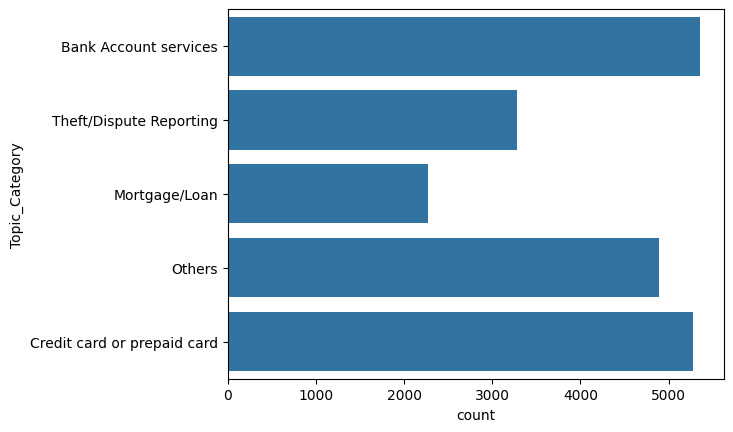

In [99]:
# Checking for Class Imbalance by creating count plot for compaints in each Topic Category
sns.countplot(data=df_clean,y=df_clean['Topic_Category'])
plt.show()

In [100]:
# As we see there is slight imbalance in data, we will use F1 Score as evaluation metrics of all model
# Creating function to evaluate the model and display the results
def eval_model(y_test,y_pred,y_pred_proba):
    #print(type,'results')
    print('Accuracy: ', round(accuracy_score(y_test,y_pred),2))
    print('Precision: ', round(precision_score(y_test,y_pred,average='weighted'),2))
    print('Recall: ', round(recall_score(y_test,y_pred,average='weighted'),2))
    print('F1 Score: ', round(f1_score(y_test,y_pred,average='weighted'),2))
    print('ROC AUC Score: ', roc_auc_score(y_test,y_pred_proba,average='weighted',multi_class='ovr').round(2))
    print('Classification Report: ', classification_report(y_test,y_pred))
    cm = confusion_matrix(y_test,y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=training_data['Topic'].unique())
    disp.plot()
    plt.show()

###**Model 1: Logistic Regression**

In [81]:
# Write your code here to build any 3 models and evaluate them using the required metrics

#Logistic Regressing

log_reg = LogisticRegression() # Inititating Model
log_reg.fit(X_train,y_train) # Fitting data
y_pred_lr = log_reg.predict(X_test) #Getting Predictions

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      1064
           1       0.89      0.92      0.90      1077
           2       0.90      0.91      0.91       951
           3       0.74      0.63      0.68       662
           4       0.91      0.85      0.88       461

    accuracy                           0.86      4215
   macro avg       0.86      0.85      0.85      4215
weighted avg       0.86      0.86      0.86      4215



Logistic Regression Results:

Accuracy:  0.86
Precision:  0.86
Recall:  0.86
F1 Score:  0.86
ROC AUC Score:  0.98
Classification Report:                precision    recall  f1-score   support

           0       0.85      0.92      0.88      1064
           1       0.89      0.92      0.90      1077
           2       0.90      0.91      0.91       951
           3       0.74      0.63      0.68       662
           4       0.91      0.85      0.88       461

    accuracy                           0.86      4215
   macro avg       0.86      0.85      0.85      4215
weighted avg       0.86      0.86      0.86      4215



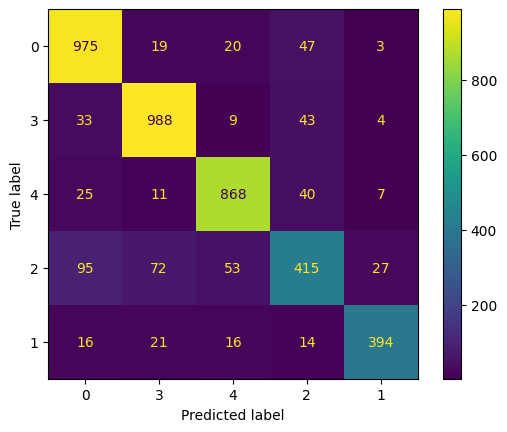

In [92]:
# Checking Model Performace
print("Logistic Regression Results:\n")
eval_model(y_test,y_pred_lr,log_reg.predict_proba(X_test))

**Model 1 Result:** With Logistic Regression model we are getting F1 Score of ~86 %

###**Model 2: Decision Tree**

In [83]:
# Decision Tree

dt = DecisionTreeClassifier() #Initiating Model
dt.fit(X_train,y_train) # Fitting Data
y_pred_dt = dt.predict(X_test) #Getting Predictions

              precision    recall  f1-score   support

           0       0.75      0.75      0.75      1064
           1       0.75      0.78      0.76      1077
           2       0.81      0.78      0.79       951
           3       0.57      0.57      0.57       662
           4       0.70      0.70      0.70       461

    accuracy                           0.73      4215
   macro avg       0.72      0.72      0.72      4215
weighted avg       0.73      0.73      0.73      4215



Decision Tree Results:

Training results
Accuracy:  0.73
Precision:  0.73
Recall:  0.73
F1 Score:  0.73
ROC AUC Score:  0.83
Classification Report:                precision    recall  f1-score   support

           0       0.75      0.75      0.75      1064
           1       0.75      0.78      0.76      1077
           2       0.81      0.78      0.79       951
           3       0.57      0.57      0.57       662
           4       0.70      0.70      0.70       461

    accuracy                           0.73      4215
   macro avg       0.72      0.72      0.72      4215
weighted avg       0.73      0.73      0.73      4215



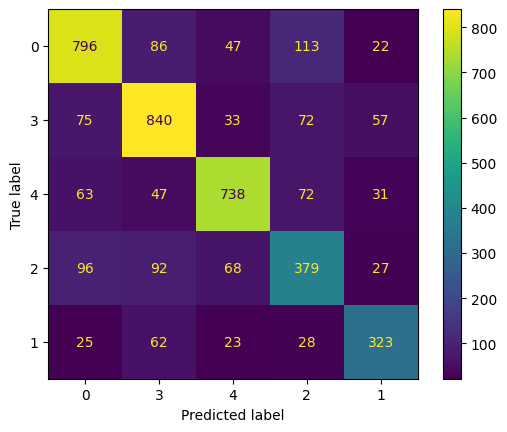

In [89]:
#Checking model performance
print("Decision Tree Results:\n")
eval_model(y_test,y_pred_dt,dt.predict_proba(X_test))

**Model 2 Result:** With Decision Tree model we are getting F1 Score of ~73 %

###**Model 3: Random Forest**

In [85]:
# Ramdom Forest

rf = RandomForestClassifier(n_estimators=100) #Inititating Model
rf.fit(X_train, y_train) #Fitting Data
y_pred_rf = rf.predict(X_test) #Getting Predictions

Random Forest Results:
              precision    recall  f1-score   support

           0       0.73      0.91      0.81      1064
           1       0.70      0.90      0.79      1077
           2       0.81      0.86      0.84       951
           3       0.84      0.18      0.30       662
           4       0.86      0.65      0.74       461

    accuracy                           0.75      4215
   macro avg       0.79      0.70      0.69      4215
weighted avg       0.77      0.75      0.72      4215



Random Forest Results:

Training results
Accuracy:  0.75
Precision:  0.77
Recall:  0.75
F1 Score:  0.72
ROC AUC Score:  0.95
Classification Report:                precision    recall  f1-score   support

           0       0.73      0.91      0.81      1064
           1       0.70      0.90      0.79      1077
           2       0.81      0.86      0.84       951
           3       0.84      0.18      0.30       662
           4       0.86      0.65      0.74       461

    accuracy                           0.75      4215
   macro avg       0.79      0.70      0.69      4215
weighted avg       0.77      0.75      0.72      4215



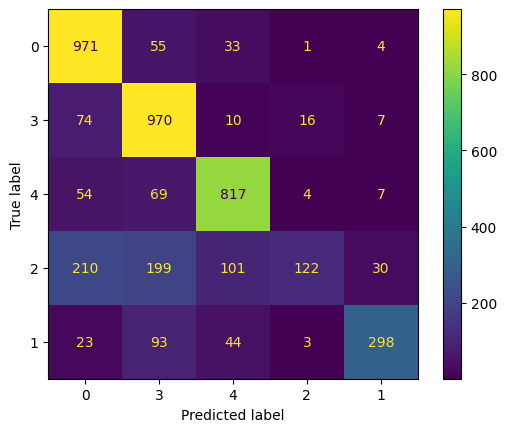

In [88]:
#Checking Model Performance
print("Random Forest Results:\n")
eval_model(y_test,y_pred_rf,rf.predict_proba(X_test))

**Model 3 Result:** With Random Forest model we are getting F1 Score of ~72 %

###**Model 4: Naive Bayes**

In [93]:
nb = MultinomialNB() #Inititaing Model
nb.fit(X_train, y_train) # Fitting Data
y_pred_nb = nb.predict(X_test) # Getting Predictions

Naïve Bayes Results
Accuracy:  0.65
Precision:  0.68
Recall:  0.65
F1 Score:  0.58
ROC AUC Score:  0.9
Classification Report:                precision    recall  f1-score   support

           0       0.65      0.90      0.75      1064
           1       0.58      0.84      0.69      1077
           2       0.72      0.82      0.77       951
           3       0.70      0.01      0.02       662
           4       0.91      0.19      0.31       461

    accuracy                           0.65      4215
   macro avg       0.71      0.55      0.51      4215
weighted avg       0.68      0.65      0.58      4215



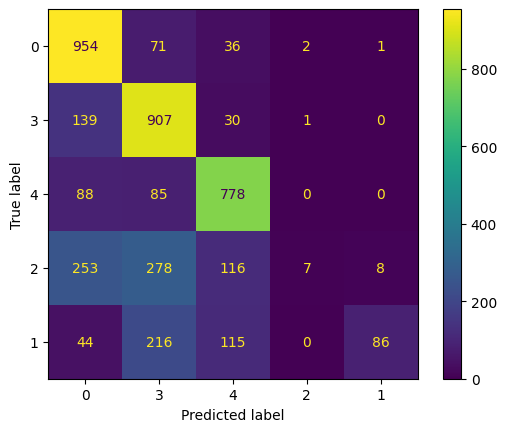

In [94]:
print("Naïve Bayes Results")
#print(classification_report(y_test, y_pred_nb))
eval_model(y_test,y_pred_nb,nb.predict_proba(X_test))

**Model 4 Result:** With Naive Bayes  model we are getting F1 Score of ~58 %

In [101]:
# Comparing Results for all Models
models = {
    "Logistic Regression": y_pred_lr,
    "Decision Tree": y_pred_dt,
    "Random Forest": y_pred_rf,
    "Naïve Bayes": y_pred_nb
}

# Create DataFrame for comparison
comparison_df = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "F1 Score"])

for model_name, y_pred in models.items():
    comparison_df.loc[model_name] = [
        round(accuracy_score(y_test, y_pred),2),
        round(precision_score(y_test, y_pred, average='weighted'),2),
        round(recall_score(y_test, y_pred, average='weighted'),2),
        round(f1_score(y_test, y_pred, average='weighted'),2)
    ]

# Sort by F1-score (best metric for imbalance)
comparison_df = comparison_df.sort_values(by="F1 Score", ascending=False)
print(comparison_df)

                     Accuracy  Precision  Recall  F1 Score
Logistic Regression      0.86       0.86    0.86      0.86
Decision Tree            0.73       0.73    0.73      0.73
Random Forest            0.75       0.77    0.75      0.72
Naïve Bayes              0.65       0.68    0.65      0.58


### **Final Recommendation :** After Comparing results for all models we conclude that Logistic Regression model is giving best overall performance

**End of Notebook**

